# Data Profiler Notebook

## Setup

### Import relevant modules

In [1]:
import pandas
import numpy
import random
import datetime
import math
import json
import seaborn
import matplotlib.pyplot as plt
from functools import reduce

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Set seaborn grid and figuresize

In [2]:
seaborn.set(rc = {"figure.figsize":(16,12)})
seaborn.set_style("whitegrid")

### Grab current timestamp

In [3]:
# get timestamp
now = datetime.datetime.now()
timestamp = now.strftime("%Y%m%d") + "_"

print("Timestamp set to: {}".format(timestamp))

Timestamp set to: 20180810_


## Settings
- Fill in the parameters within Settings subsections and run all cells to generate report

#### Import data settings
- First import your data into a pandas dataframe (mandatory)
- You can use `pandas`' `read_csv()`, `read_excel()`, `read_json()` methods to read in data

In [4]:
data_path = "/users/danielcorcoran/desktop/\
github_repos/python_nb_visualization/\
seaborn_official_datasets/iris.csv"

data = pandas.read_csv(data_path)

print("Dataframe has {} features and {} records".format(data.shape[1], data.shape[0]))

Dataframe has 5 features and 150 records


In [5]:
print("Dataframe feature names: {}".format(list(data.columns)))

Dataframe feature names: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']


#### Export settings
- Set your `exportpath`. The profiler will export the .csv/.json report as well as visualization .png/.svgs to this folder.

In [6]:
exportpath = "/users/danielcorcoran/desktop/github_repos/python_nb_data_profiling/exports/"

print("Export path set to '{}'".format(exportpath))

Export path set to '/users/danielcorcoran/desktop/github_repos/python_nb_data_profiling/exports/'


#### Report Settings 
- Set report width and spacing chars (optional)
- `report_width` is the width in chars of the report printed out in step `1.7 Data Profile Results`
- `header_spacing_char` is the char used to pad the report column headers eg. "##### age (1/12) #####" for "#"
- `attribute_spacing_char` is the char used to pad the attribute value pairing eg. "mean:___34" for "_"

In [7]:
report_width = 80
just_width = math.floor(report_width / 2)
attribute_spacing_char = " "
header_spacing_char = "~"

print("Report width set to {}".format(report_width))
print("Attribute spacing char set to '{}'".format(attribute_spacing_char))
print("Header spacing char set to '{}'".format(header_spacing_char))

Report width set to 80
Attribute spacing char set to ' '
Header spacing char set to '~'


#### Visualization Settings
- `visualize_dataset` if this is set to True, the dataset will be visualized using `seaborn`'s `.pairplot()` and `heatmap()`
- `deal_with_nulls` set this to 'mean' to imputate missing values, or 'remove' to drop them entirely.
- `palette` seaborn palette. Visit https://seaborn.pydata.org/tutorial/color_palettes.html for more info.
- `nunique_range` Categorical features with unique items between this range will be visualized in the `.pairplot()`
- `features_to_exclude` A list of features to exclude from visualization data.
- `identity_type` Set this to 'kde' for kernel density or 'hist' for histogram.
- `non_identity_type` Set this to 'scatter' for scatterplot or 'reg' for regression.

In [8]:
visualize_dataset = True
features_to_exclude = ['x', 'y', 'z']
deal_with_nulls = "mean"
nunique_range = [2,10]
palette = "Dark2"
identity_type = 'hist'
non_identity_type = 'scatter'

## Extract Data Profiles

### Get Statistical Summary

In [9]:
#call pandas describe method on dataframe
describe = data.describe(include = "all")

#transpose
describe_transposed = describe.T

#reset_index, moving the column names into a new series
describe_final = describe_transposed.reset_index()

In [10]:
describe_final

,index,count,unique,top,freq,mean,std,min,25%,50%,75%,max
0,sepal_length,150,NaN,NaN,NaN,5.84333,0.828066,4.3,5.1,5.8,6.4,7.9
1,sepal_width,150,NaN,NaN,NaN,3.05733,0.435866,2,2.8,3,3.3,4.4
2,petal_length,150,NaN,NaN,NaN,3.758,1.7653,1,1.6,4.35,5.1,6.9
3,petal_width,150,NaN,NaN,NaN,1.19933,0.762238,0.1,0.3,1.3,1.8,2.5
4,species,150,3,setosa,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Get Data Types

In [11]:
# get datatypes of each feature
dtypes = data.dtypes

In [12]:
#convert to dataframe and rename a column
dtypes_dataframe = pandas.DataFrame(dtypes, columns = ["data_type"])

In [13]:
# reset index, moving the column names into a new series
dtypes_final = dtypes_dataframe.reset_index()

In [14]:
# preview
dtypes_final.head()

,index,data_type
0,sepal_length,float64
1,sepal_width,float64
2,petal_length,float64
3,petal_width,float64
4,species,object


### Get Null composition

In [15]:
#use notnull() and isnull() methods combined with sum() to
#get null composition of dataset
filled_count_series = data.notnull().sum().astype(int)
null_count_series = data.isnull().sum().astype(int)

#get amount of rows in dataset
totalcount = data.shape[0]

In [16]:
#create percentage series based on series above
percent_null =  null_count_series / totalcount
percent_filled = filled_count_series / totalcount

In [17]:
percent_null = percent_null.reset_index().rename(columns = {0:"null_percent"})
percent_filled = percent_filled.reset_index().rename(columns = {0:"non_null_percent"})
filled_count_series = filled_count_series.reset_index().rename(columns = {0:"non_null_counts"})
null_count_series = null_count_series.reset_index().rename(columns = {0:"null_counts"})

In [18]:
null_info_dataframe = reduce(lambda left,right: pandas.merge(left,right,on='index'), [percent_null,
                                                                                 percent_filled,
                                                                                 filled_count_series,
                                                                                 null_count_series])

In [19]:
null_info_dataframe.head()

,index,null_percent,non_null_percent,non_null_counts,null_counts
0,sepal_length,0.0,1.0,150,0
1,sepal_width,0.0,1.0,150,0
2,petal_length,0.0,1.0,150,0
3,petal_width,0.0,1.0,150,0
4,species,0.0,1.0,150,0



### Merge all

In [20]:
merged = reduce(
    lambda left, right: pandas.merge(left, right, on='index', how="left"),
    [null_info_dataframe, dtypes_final, describe_final])

### Cleanup: Drop count column

In [21]:
merged["row_count"] = totalcount

merged.drop(["count"], axis = 1, inplace = True)

In [22]:
merged.head()

,index,null_percent,non_null_percent,non_null_counts,null_counts,data_type,unique,top,freq,mean,std,min,25%,50%,75%,max,row_count
0,sepal_length,0.0,1.0,150,0,float64,NaN,NaN,NaN,5.84333,0.828066,4.3,5.1,5.8,6.4,7.9,150
1,sepal_width,0.0,1.0,150,0,float64,NaN,NaN,NaN,3.05733,0.435866,2,2.8,3,3.3,4.4,150
2,petal_length,0.0,1.0,150,0,float64,NaN,NaN,NaN,3.758,1.7653,1,1.6,4.35,5.1,6.9,150
3,petal_width,0.0,1.0,150,0,float64,NaN,NaN,NaN,1.19933,0.762238,0.1,0.3,1.3,1.8,2.5,150
4,species,0.0,1.0,150,0,object,3,setosa,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150


### Cleanup: Calculate unique values for numerical features

In [23]:
# Fill in gaps in unique column with nunique method

for index in range(merged.shape[0]):
    
    unique_value = merged.loc[index, "unique"]
    
    if numpy.isnan(unique_value):
        
        feature_name = merged.loc[index, "index"]
        
        
        number_of_uniques = data[feature_name].nunique()
        merged.loc[index, "unique"] = number_of_uniques
        print("Feature {} unique values being calculated and adjusted to {}".format(feature_name, number_of_uniques))

Feature sepal_length unique values being calculated and adjusted to 35
Feature sepal_width unique values being calculated and adjusted to 23
Feature petal_length unique values being calculated and adjusted to 43
Feature petal_width unique values being calculated and adjusted to 22


### Cleanup: Change types

In [24]:
# Changing type of datatype column to string
merged["data_type"] = merged["data_type"].astype(str)

### Cleanup: Round values

In [25]:
unique_datatypes = list(merged["data_type"].unique())

print("Unique datatypes in this dataset are: {}".format(unique_datatypes))

if "float64" in unique_datatypes or "int64" in unique_datatypes:
    
    round_values = True
    rounded_places = 4
    
    for column in ["mean", "std", "min", "25%", "50%", "75%", "max"]:
        
        merged[column] = merged[column].astype(float).round(rounded_places)
else:
    round_values = False

Unique datatypes in this dataset are: ['float64', 'object']


### Create Data Profile Dictionary

In [26]:
profile_dict = {}

In [27]:
# Store list of features relevant to dictionary
merged_attributes = list(merged.columns)
merged_attributes.remove("index")

# Iterate through merged records
for index in range(merged.shape[0]):
    
    # Store column name
    column = merged.loc[index, "index"]
    
    # Create empty list, to store sub dictionaries in
    profile_dict[column] = []
    
    # For each attribute in merged_attributes list do this
    for attr in merged_attributes:
        
        # Locate the value of the attribuet for a given record
        value = merged.loc[index, attr]
        
        # Append dictionary to list within main dictionary
        profile_dict[column].append({attr: value})

## Export results as .json and .csv

### Helper Function to convert invalid json values

In [28]:
# will try to convert a value to a float, followed by string,
# if the float conversion fails

def convert_invalid_values(value):
    
    try:
        new_value = float(value)
    except:
        new_value = str(value)

    return new_value

### Export as json

In [29]:
with open(exportpath + "profile.json", "w") as fileobj:
    # for errors I want to attempt to convert the value to a float before str using
    # the function defined above
    json.dump(profile_dict, fileobj, default = convert_invalid_values)
    
fileobj.close()

### Export as csv

In [30]:
merged.to_csv(exportpath + "profile.csv", index = False)

## Data Profile Results 

In [31]:
total_keys = len(profile_dict.keys())
column_number = 0

In [32]:
for key in profile_dict.keys():
    
    # Increment column number
    column_number = column_number + 1
    
    # Calculate column pos
    column_pos = " ({}/{})"
    
    print("\n", (" " + key + " ").center(report_width, header_spacing_char))
    
    sub_dictionary = profile_dict[key]
    for dictionary in sub_dictionary:
        
        keys = list(dictionary.keys())
        attribute = keys[0]
        value = dictionary[attribute]
        
        if "percent" in attribute:
            formatted_value = "{0:.2%}".format(value)
        else:
            formatted_value = str(value)
        
        print(attribute.ljust(just_width, attribute_spacing_char), 
              formatted_value.rjust(just_width, attribute_spacing_char))


 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ sepal_length ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
null_percent                                                                0.00%
non_null_percent                                                          100.00%
non_null_counts                                                               150
null_counts                                                                     0
data_type                                                                 float64
unique                                                                         35
top                                                                           nan
freq                                                                          nan
mean                                                                       5.8433
std                                                                        0.8281
min                                                                           4.3
25%            

## Visualizations
(Optional)

### Pairplot

#### Create subset of data without nulls for visualizing
- Will react to `deal_with_nulls` variable

In [33]:
d = "this"

if d in ["this is", "that"]:
    print("true")

In [34]:
list(merged[(merged["data_type"] == "int64") | 
            (merged["data_type"] == "float64")]["index"])

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [35]:
if visualize_dataset == True:
    
    if deal_with_nulls == "remove":
        
        # Print message
        print("Nulls will be removed from visualization dataset.")
        
        # Remove each record containing any nulls
        data_no_nulls = data.dropna(how = "any", axis = 0)

        print("Shape of original dataset {}"\
              .format(data.shape))
        print("Shape of visualization dataset {}. \n{} Records were removed (containing nulls)."\
              .format(data_no_nulls.shape, data.shape[0] - data_no_nulls.shape[0]))
    else:
        # Print message
        
        print("Nulls will be replaced by the mean of each numeric feature.")
        
        # Find each column of numeric quality and store in list
        columns_to_fill_mean = list(
                merged[(merged["data_type"] == "int64") | 
                (merged["data_type"] == "float64")]["index"])
        
        data_no_nulls = data
        
        # For each column in list fill the dataset with the mean of that column
        for column in columns_to_fill_mean:
            data_no_nulls[column] = data_no_nulls[column].fillna(data_no_nulls[column].mean())

Nulls will be replaced by the mean of each numeric feature.


#### Drop columns from visualization dataset
- These features are listed in `features_to_exclude` variable

In [36]:
data_no_nulls_column_list = list(data_no_nulls.columns)

if visualize_dataset == True:
    for feature in features_to_exclude:
        if feature in data_no_nulls_column_list:
            data_no_nulls.drop([feature], axis = 1, inplace = True)
            print("{} removed from visualization dataset".format(feature))

#### Calculate chosen_categorical_features (features with unique number of items between given range)

In [37]:
if visualize_dataset == True:

    # Create subset of merged containing data type = object and nunique between range above
    chosen_categorical_features = list(merged[(merged["unique"] >= nunique_range[0]) & 
                               (merged["unique"] <= nunique_range[1]) & 
                               (merged["data_type"] == "object")]["index"])

    print("Categorical features: {}".format(chosen_categorical_features))

    # Remove unwanted features
    for feature in features_to_exclude:
        if feature in chosen_categorical_features:
            chosen_categorical_features.remove(feature)

    # Preview chosen_categorical_features
    print("Categorical features being used in pairplot: {}".format(chosen_categorical_features))

Categorical features: ['species']
Categorical features being used in pairplot: ['species']


#### Calculate which columns can be used as categories to split float data in pairplots
- Note: code hasn't accounted for datasets without float/int features yet.

#### Convert bool dtypes before visualizing, as this produces errors otherwise 

In [38]:
for column in data_no_nulls.columns:
    dtype = data_no_nulls[column].dtype
    if dtype == "bool":
        data_no_nulls[column] = data_no_nulls[column].astype(str)

<Figure size 1152x864 with 0 Axes>

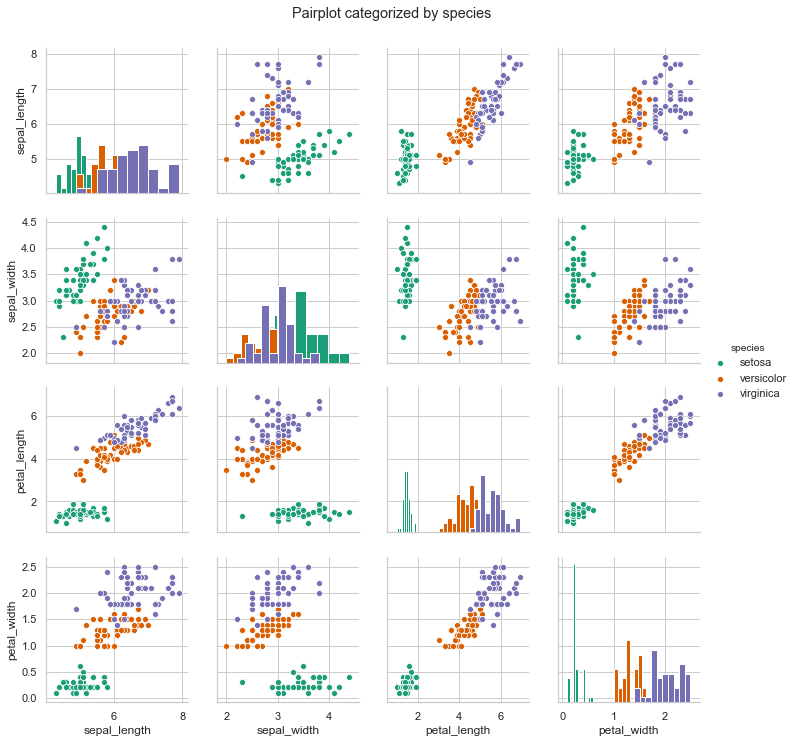

In [39]:
if visualize_dataset == True:
    
    # If dataset contains at least one categorical feature do this
    if "unique" in merged.columns:

        for column in chosen_categorical_features:

            plt.figure()
            myplot = seaborn.pairplot(data = data_no_nulls, 
                                      kind = non_identity_type,
                                      diag_kind = identity_type,
                                      hue = column,
                                      palette = palette
                                     )

            myplot.fig.suptitle("Pairplot categorized by {}".format(column), 
                         y = 1.03)

            plt.savefig(exportpath + timestamp +  column + "_pairplot.png")

    # If data set has no categorical features (only floats/ints) do this
    else:

        plt.figure()

        myplot = seaborn.pairplot(data = data_no_nulls, 
                                  kind = non_identity_type,
                                  diag_kind = identity_type
                                 )

        myplot.fig.suptitle("Pairplot", 
                     y = 1.03)

        plt.savefig(exportpath + timestamp +  "data_profile_pairplot.png")

### Correlation Heatmap

In [42]:
seaborn.set(rc = {"figure.figsize":(13,10)})
seaborn.set_style("whitegrid")

Heatmap saved to '/users/danielcorcoran/desktop/github_repos/python_nb_data_profiling/exports/20180810_heatmap.png'


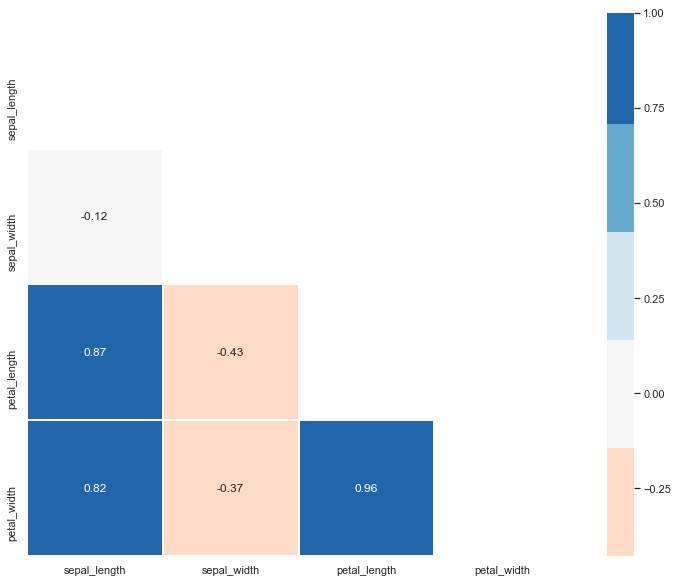

In [43]:
if visualize_dataset == True and round_values == True:
    # Save path
    heatmap_save_path = exportpath + timestamp + "heatmap.png"
    
    # Create correlation Matrix
    correlation_dataframe = data_no_nulls.corr()
    
    # Create mask
    mask = numpy.zeros_like(correlation_dataframe)
    mask[numpy.triu_indices_from(mask)] = True

    # Create heatmap, show and export as .png
    seaborn.heatmap(data = correlation_dataframe,
               cmap = ['#b2182b',
                    '#ef8a62',
                    '#fddbc7',
                    '#f7f7f7',
                    '#d1e5f0',
                    '#67a9cf',
                    '#2166ac'],
               center = 0,
               square = True,
               linewidth = 1,
               mask = mask,
               annot = True).get_figure().savefig(heatmap_save_path)
    
    print("Heatmap saved to '{}'".format(heatmap_save_path))
else:
    print("No heatmap was produced. Dataset contains no numeric features or visualize_dataset variable was set to False.")